In [25]:
import pandas as pd
from datetime import datetime

# read in the data files that were downloaded and save as df
test_df = pd.read_csv('../csv/fraudTest.csv')
train_df = pd.read_csv('../csv/fraudTrain.csv')

# remove columns to clean df
column_keep = ['merch_lat', 'merch_long', 'unix_time', 'category', 'amt', 'gender', 'lat', 'long', 'dob', 'is_fraud']

# concat dfs bc we need to use skillet train_test_split
df = pd.concat([train_df, test_df])

# clean merchant column
df['merchant'] = df['merchant'].str.split('_').str[1]

# one end code gender
df['gender'] = df['gender'].replace({'M': 0, 'F': 1})

# Create a new DataFrame with only the selected columns
df = df[column_keep]

# Encode 'category' section in df to be represented numerically (frequency based encoding)
freq_encoding = df['category'].value_counts(normalize=True)
df['category'] = df['category'].map(freq_encoding)

# convert dob to 'age'
current_year = datetime.now().year
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = current_year - df['dob'].dt.year
df.drop('dob', axis=1, inplace=True)

# display the df
df

/var/folders/8q/dh03ws3n0yx6gdjsn87pxb3c0000gn/T/ipykernel_9507/1406138880.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'M': 0, 'F': 1})


,merch_lat,merch_long,unix_time,category,amt,gender,lat,long,is_fraud,age
0,36.011293,-82.048315,1325376018,0.048939,4.97,1,36.0788,-81.1781,0,36
1,49.159047,-118.186462,1325376044,0.095115,107.23,1,48.8878,-118.2105,0,46
2,43.150704,-112.154481,1325376051,0.072403,220.11,0,42.1808,-112.2620,0,62
3,47.034331,-112.561071,1325376076,0.101506,45.00,0,46.2306,-112.1138,0,57
4,38.674999,-78.632459,1325376186,0.061666,41.96,0,38.4207,-79.4629,0,38
...,...,...,...,...,...,...,...,...,...,...
555714,39.946837,-91.333331,1388534347,0.066159,43.77,0,40.4931,-91.8912,0,58
555715,29.661049,-96.186633,1388534349,0.087307,111.84,0,29.0393,-95.4401,0,25
555716,46.658340,-119.715054,1388534355,0.087307,86.88,1,46.1966,-118.9017,0,43
555717,44.470525,-117.080888,1388534364,0.031287,7.99,0,44.6255,-116.4493,0,59


In [26]:
# Scale features down

features_to_scale = ['merch_long', 'merch_lat', 'unix_time', 'lat', 'long', 'amt', 'age']

def standardize(col):
    mean = col.mean()
    std = col.std()
    return (col - mean) / std

for feature in features_to_scale:
    df[feature] = standardize(df[feature])

df

,merch_lat,merch_long,unix_time,category,amt,gender,lat,long,is_fraud,age
0,-0.495080,0.594463,-1.830066,0.048939,-0.408741,1,-0.485167,0.658263,0,-0.845898
1,2.080081,-2.031915,-1.830065,0.095115,0.233378,1,2.040530,-2.035415,0,-0.270874
2,0.903268,-1.593534,-1.830064,0.072403,0.942183,0,0.718034,-1.602730,0,0.649165
3,1.663928,-1.623084,-1.830063,0.101506,-0.157381,0,1.516580,-1.591950,0,0.361653
4,0.026642,0.842714,-1.830057,0.061666,-0.176470,0,-0.023388,0.783024,0,-0.730893
...,...,...,...,...,...,...,...,...,...,...
555714,0.275748,-0.080335,1.641110,0.066159,-0.165105,0,0.385251,-0.120991,0,0.419155
555715,-1.738859,-0.433054,1.641110,0.087307,0.262326,0,-1.873226,-0.379132,0,-1.478425
555716,1.590285,-2.143007,1.641110,0.087307,0.105595,1,1.509876,-2.085692,0,-0.443381
555717,1.161772,-1.951566,1.641111,0.031287,-0.389777,0,1.200084,-1.907308,0,0.476658


In [27]:
from sklearn.model_selection import train_test_split

y = df['is_fraud']
X = df.drop(columns='is_fraud')

# Split data into training set and testing set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

# Convert to numpy arrays
Xtrain = Xtrain.values
Xtest = Xtest.values
ytrain = ytrain.values
ytest = ytest.values

In [28]:
from sklearn.metrics import r2_score
import numpy as np

def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew
# TAKEN FROM MOHIT'S METHOD ON HW4 ^^^

In [29]:
def sigmoid(z):
    """
    Compute the sigmoid of inputted scalar or array.
    
    Args:
        z: A scalar or numpy array of any size.
        
    Returns:
        The sigmoid of z.
    """
    return 1 / (1 + np.exp(-z))

In [30]:
def compute_cost(X, y, theta, class_weights):
    """
    Compute the cost of model after training.
    
    Args:
        X: Feature matrix
        y: Labels vector
        theta: Parameter vector
        class_weights: The class weights we are using to try and reduce false negatives.
        
    Returns:
        cost: The logistic regression cost
    """
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    epsilon = 1e-5
    cost = (-1 / m) * (
        class_weights[1] * np.dot(y.T, np.log(h + epsilon)) +
        class_weights[0] * np.dot((1 - y).T, np.log(1 - h + epsilon))
    )
    return cost

In [31]:
def compute_gradient(X, y, theta, class_weights):
    """
    Compute the gradient of weight instance.
    
    Args:
        X: Feature matrix
        y: Labels vector
        theta: Parameter vector
        class_weights: Class weights to reduce imbalance
        
    Returns:
        gradient: The gradient vector
    """
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    # Apply class weights
    error = h - y
    error_weighted = np.where(y == 1, class_weights[1] * error, class_weights[0] * error)
    gradient = (1 / m) * np.dot(X.T, error_weighted)
    return gradient

In [32]:
from sklearn.utils import class_weight

def logistic_regression_train(X, y, alpha=0.01, num_iterations=1000, class_weights=None):
    """
    Trains logistic regression model using gradient descent.
    
    Args:
        X: Feature matrix
        y: Labels vector
        alpha: Learning rate (Starting value of 0.01)
        num_iterations: Number of iterations
        
    Returns:
        theta: The trained parameter vector
        cost_history: The history of cost function
    """
    if class_weights is None:
        class_weights = {0: 1, 1: 1}


    m, n = X.shape
    theta = np.zeros((n, 1))
    y = y.reshape(-1, 1)
    cost_history = []
    
    for i in range(num_iterations):
        cost = compute_cost(X, y, theta, class_weights)
        gradient = compute_gradient(X, y, theta, class_weights)
        theta = theta - alpha * gradient
        cost_history.append(cost[0][0])
        
        # Print the cost every 100 iterations
        if i % 100 == 0:
            print(f'Iteration {i}: Cost {cost[0][0]}')
    return theta, cost_history


In [33]:
def logreg_classify(Xnew, ynew, m, threshold):
    """
    Args:
        Xnew: Features (input x for all weights)
        ynew: Expected output for feature set
        m: Weights vector
        threshold: Classification threshold

    Returns:
        A dictionary containing:
            'ypreds': The predicted values from applying m to Xnew
            'classified_preds': The classified prediction from the model
            'probabilities': The probabilities (sigmoid of ypreds)
            'resids': The residuals, and the differences between ynew and ypreds
            'mse': The mean squared error
            'r2': The coefficient of determination (R^2)
            'accuracy': Accuracy of model against test set
    """
    # Add bias column
    Xnew_bias = add_bias_column(Xnew)
    
    # Make prediction
    ypreds = np.dot(Xnew_bias, m)

    # Calculate probabilities using sigmoid function
    probabilities = sigmoid(ypreds)
    
    # Classify prediction
    classified_preds = (probabilities >= threshold).astype(int)
    
    # Calculate residuals
    resids = ynew.reshape(-1, 1) - probabilities
    
    # Calculate MSE
    mse = np.mean(resids**2)
    
    # Calculate accuracy against test set
    accuracy = np.mean(classified_preds == ynew.reshape(-1, 1))
    
    return {
        'ypreds': ypreds,
        'classified_preds': classified_preds,
        'probabilities': probabilities,
        'resids': resids,
        'mse': mse,
        'accuracy': accuracy
    }
# TAKEN FROM LIAMS HW4
# SLIGHTLY ALTERED

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def train_logistic_regression(Xtrain, ytrain, Xtest, ytest, alpha=0.0275, num_iterations=1000, threshold=0.5):
    """
    Trains logistic regression model using gradient descent and evaluates on test data.
    
    Args:
        Xtrain: Training features
        ytrain: Training labels
        Xtest: Test features
        ytest: Test labels
        alpha: Learning rate
        num_iterations: Maximum number of iterations
        threshold: Classification threshold
        
    Returns:
        A dictionary containing:
            'theta': The trained parameter vector
            'cost_history': History of cost function
            'accuracy': Accuracy of guesses on test set
            'mse': Mean squared error on test set
            'resids': Residuals on test set
            'ypreds': Predicted values
            'probabilities': Predicted probabilities
            'classified_preds': Predicted class labels
            'confusion_matrix': Confusion matrix on test set
            'classification_report': Sklearn classification report on test set
    """

    # Calculate class weights
    classes = np.unique(ytrain)
    class_weights_values = class_weight.compute_class_weight('balanced', classes=classes, y=ytrain)
    class_weights = dict(zip(classes, class_weights_values))
    
    # Add bias column
    Xtrain_bias = add_bias_column(Xtrain)
    
    # Train logistic regression
    theta, cost_history = logistic_regression_train(Xtrain_bias, ytrain, alpha, num_iterations, class_weights)
    
    # Use linreg_classify to make predictions and compute metrics
    test_results = logreg_classify(Xtest, ytest, theta, threshold)
    
    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(ytest, test_results['classified_preds'])
    class_report = classification_report(ytest, test_results['classified_preds'], zero_division=0)
    
    # Include cost_history and theta in the results
    test_results['theta'] = theta
    test_results['cost_history'] = cost_history
    test_results['confusion_matrix'] = conf_matrix
    test_results['classification_report'] = class_report
    
    return test_results


In [35]:
results = train_logistic_regression(Xtrain, ytrain, Xtest, ytest, alpha=0.0275, num_iterations=1000, threshold=0.51)

# Display the results
print('Accuracy:', results['accuracy'])
print('Confusion Matrix:\n', results['confusion_matrix'])
print('Classification Report:\n', results['classification_report'])


Iteration 0: Cost 0.6931271807600741
Iteration 100: Cost 0.47454524201996445
Iteration 200: Cost 0.4463968867041326
Iteration 300: Cost 0.4349979386734731
Iteration 400: Cost 0.4294905983988265
Iteration 500: Cost 0.42647991630034876
Iteration 600: Cost 0.4246640482579365
Iteration 700: Cost 0.4234783033360073
Iteration 800: Cost 0.42265304577266716
Iteration 900: Cost 0.422048894763035
Accuracy: 0.9548656785173801
Confusion Matrix:
 [[528456  24397]
 [   685   2181]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    552853
           1       0.08      0.76      0.15      2866

    accuracy                           0.95    555719
   macro avg       0.54      0.86      0.56    555719
weighted avg       0.99      0.95      0.97    555719



Initially when we trained this model, the accuracy was left around 99.47%, which was the exact same as in our logistic regression classification model. I thought this was unideal, so I searched for ways to reduce class imbalance overall, as 99% of transactions in our dataset are non-fraudulent. The way I found to do this was by incorporating class weights, which will allow the model to better understand the distribution of positive vs negative classifications.

This was our previous 'Confusion Matrix:'
[[552811     66]
 [  2842      0]]
The way you read this is the top left is true negatives, top right is false positives
Bottom left is false negatives, bottom right is true positive.
But, again, this is with 99.47% accuracy. Thats important to note because it shows just how many of these transactions are not fraudulent.

So, you can see that we didn't manage to correctly classify a SINGLE transaction as fraudulent before we implemented class weights. This is what our matrix looked like after implementing class_weights:

[[528456  24397]
 [   685   2181]]

So you can see: 528456 true negatives, 24397 false positives, 685 false negatives, 2181 true positives. And our accuracy in this situation was down to 95.48%. 

Even though the accuracy went down overall, the meaning of this is ambiguous. In our previous confusion matrix, we didn't get a single true positive classified fraudulent transaction. In this version with class weights, we have gotten 2181. The inclusion of class weights has made our model more skeptical of transactions, and even though it may have a lower accuracy, it has an infinitely larger true positive rate when compared to the model without class weights. This for our purpose is highly beneficial, as we are far more likely to detect suspicious transactions than previous.

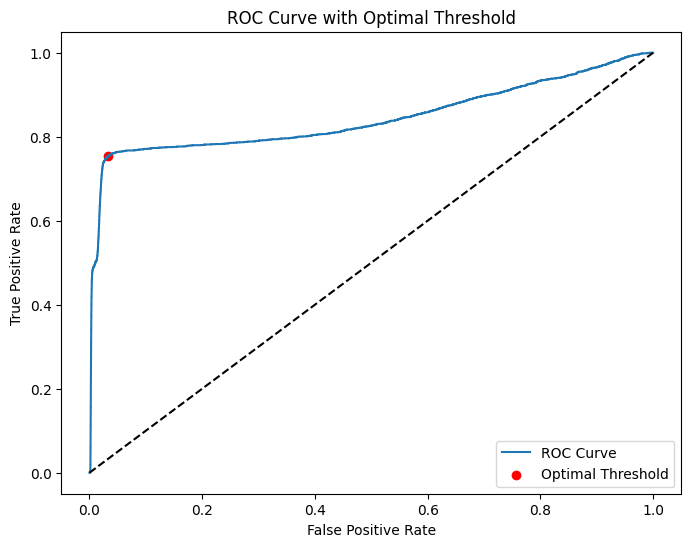

Optimal Threshold (Youden's J): 0.5520987900548144


In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

probabilities = results['probabilities'].flatten()
fpr, tpr, thresholds = roc_curve(ytest, probabilities)

youdens_j = tpr - fpr
optimal_index = np.argmax(youdens_j)
optimal_threshold = thresholds[optimal_index]


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier

# Mark the optimal point
plt.scatter(fpr[optimal_index], tpr[optimal_index], marker='o', color='red', label='Optimal Threshold')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Threshold')
plt.legend(loc='lower right')
plt.show()
print('Optimal Threshold (Youden\'s J):', optimal_threshold)



In [43]:
# Update the threshold in linreg_classify
test_results = logreg_classify(Xtest, ytest, results['theta'], threshold=optimal_threshold)

conf_matrix = confusion_matrix(ytest, test_results['classified_preds'])
class_report = classification_report(ytest, test_results['classified_preds'], zero_division=0)

print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)


Confusion Matrix:
 [[534366  18487]
 [   703   2163]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    552853
           1       0.10      0.75      0.18      2866

    accuracy                           0.97    555719
   macro avg       0.55      0.86      0.58    555719
weighted avg       0.99      0.97      0.98    555719



After finding and using the best threshold, we found that our model once again improved.

You can see that even though our TP decreased (only by around 18) and our FN increased (by like 20) our false positive rate decreased by around 6000. This is a significant improvement to the model because even though we get a few less true positives, the vast amount of false positives we are avoiding now is much better.

In [48]:
# for whoever is adding on code for analyzing this results is what you want
results['resids']
results 

{'ypreds': array([[-1.36748003],
        [-0.99758895],
        [-1.07249329],
        ...,
        [-0.59798925],
        [-1.41117904],
        [-0.74747041]]),
 'classified_preds': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]),
 'probabilities': array([[0.20302729],
        [0.26941573],
        [0.25492922],
        ...,
        [0.35480386],
        [0.19604816],
        [0.32137273]]),
 'resids': array([[-0.20302729],
        [-0.26941573],
        [-0.25492922],
        ...,
        [-0.35480386],
        [-0.19604816],
        [-0.32137273]]),
 'mse': np.float64(0.09662311298131723),
 'accuracy': np.float64(0.9548656785173801),
 'theta': array([[-8.18458991e-01],
        [ 3.09242959e-03],
        [-7.46223027e-04],
        [-1.92558770e-01],
        [-5.06620976e-02],
        [ 1.17502227e+00],
        [-1.68885211e-01],
        [ 6.86395043e-03],
        [ 5.65245319e-04],
        [ 8.50611375e-02]]),
 'cost_history': [np.float64(0